In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_absolute_error
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
import lightgbm as lgb

# Анализ данных

## Анализ таблицы data_arc

In [2]:
### таблица 1
df_1 = pd.read_csv('/datasets/final_steel/data_arc.csv', sep = ',')
df_1.info()
display(df_1.head(20))
columns_date = list(df_1.columns)[1:3]
for i in columns_date:
    df_1[i] = pd.to_datetime(df_1[i], format = '%Y-%m-%d %H:%M:%S') 
df_1['время нагрева дугой'] = (df_1['Конец нагрева дугой'] - df_1['Начало нагрева дугой']).astype('timedelta64[s]')
df_1['полная мощность'] = (df_1['Активная мощность']**2 + df_1['Реактивная мощность']**2)**0.5 
df_1 = df_1[['key', 'Активная мощность', 'Реактивная мощность', 'время нагрева дугой', 'полная мощность']]
df_1_2 = df_1.groupby('key').agg({'Активная мощность': 'sum', 'время нагрева дугой': 'sum', 'Реактивная мощность': 'sum', 'полная мощность':'sum'})
df_1_2['совершенная работа'] = df_1_2['полная мощность']* df_1_2['время нагрева дугой'] 
print(df_1_2['совершенная работа'].describe())
display(df_1_2.sort_values(by = 'совершенная работа', ascending =False).head(20))
display(df_1_2.sort_values(by = 'совершенная работа', ascending =False).tail(20))
df_1_2 = df_1_2.drop([2116], axis = 0)
df_1_2['key'] = df_1_2.index
df_1_2.reset_index(inplace = True, drop = True)
df_1_2 = df_1_2[['key', 'полная мощность' ,'Активная мощность', 'Реактивная мощность', 'время нагрева дугой', 'совершенная работа']]
display(df_1_2.head(20))
df_1_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


count      3214.000000
mean       3749.668259
std        6497.377736
min          15.158096
25%        1536.798599
50%        2897.948071
75%        4769.106618
max      310520.574205
Name: совершенная работа, dtype: float64


,Активная мощность,время нагрева дугой,Реактивная мощность,полная мощность,совершенная работа
key,,,,,
2116,1.848681,433.0,-714.591636,717.137585,310520.574205
1689,17.496497,4189.0,12.587990,21.564771,90334.826897
46,12.361625,2919.0,8.369891,14.931955,43586.376479
1880,11.387710,2755.0,9.866436,15.200850,41878.341438
2108,10.426942,2739.0,10.072821,14.567053,39899.156966
322,9.521275,2658.0,8.020549,12.472925,33153.033419
1513,9.910345,2526.0,8.135789,12.848380,32455.008714
813,8.070847,2247.0,8.876344,12.073120,27128.299993
45,9.184464,2136.0,6.563533,11.294439,24124.920793


,Активная мощность,время нагрева дугой,Реактивная мощность,полная мощность,совершенная работа
key,,,,,
3026,0.444809,126.0,0.334250,0.556397,70.106078
248,0.448348,127.0,0.313810,0.547259,69.501930
246,0.432823,129.0,0.315280,0.535478,69.076720
1974,0.454900,117.0,0.373960,0.588880,68.898966
556,0.436405,125.0,0.334664,0.549954,68.744247
1048,0.427210,130.0,0.304516,0.524663,68.206149
1911,0.438719,124.0,0.316818,0.541155,67.103164
1479,0.428204,127.0,0.307569,0.527296,66.966633
3112,0.438403,124.0,0.310234,0.537068,66.596433


,key,полная мощность,Активная мощность,Реактивная мощность,время нагрева дугой,совершенная работа
0,1,5.826395,4.878147,3.183241,1098.0,6397.381637
1,2,3.649216,3.052598,1.998112,811.0,2959.514496
2,3,2.989534,2.525882,1.599076,655.0,1958.144876
3,4,3.814962,3.209250,2.060298,741.0,2826.887120
4,5,4.035758,3.347173,2.252643,869.0,3507.073549
5,6,4.786837,3.955108,2.689175,952.0,4557.068653
6,7,2.987777,2.547375,1.561295,673.0,2010.774053
7,8,4.627389,3.762755,2.680698,913.0,4224.805757
8,9,2.555348,2.081951,1.478671,625.0,1597.092768
9,10,3.851739,2.923622,2.496116,825.0,3177.684917


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 6 columns):
key                    3213 non-null int64
полная мощность        3213 non-null float64
Активная мощность      3213 non-null float64
Реактивная мощность    3213 non-null float64
время нагрева дугой    3213 non-null float64
совершенная работа     3213 non-null float64
dtypes: float64(5), int64(1)
memory usage: 150.7 KB


В ходе анализа произведено преобразование типа данных для столбца с датой, определена активная и реактивная мощность и суммарное время воздействия для каждой итерации. Удалена итерация с чрезмерно большой мощностью. Также для данной таблицы рассчитаны работа и полная мощность с целью выявления наиболее качественных признаков (в дальнейшем оказалось, что по изначальным признакам модель предсказывает конечную температуру лучше). 

## Анализ таблиц data_bulk_time и data_wire_time

In [3]:
def change_dataset(df_2):
    df_2 = df_2.fillna('1900-01-01 00:00:00')
    columns_date = list(df_2.columns)[1:len(list(df_2.columns))+1]
    for i in columns_date:
        df_2[i] = pd.to_datetime(df_2[i], format = '%Y-%m-%d %H:%M:%S')
    df_2_trans = df_2.transpose()
    list_keys = (df_2_trans[df_2_trans[0] == 1].values.tolist())[0]
    df_without_keys = df_2_trans.drop(index = ['key'],axis = 0)
    list_max_time = []
    columns_date_trans = list(df_without_keys.columns)
    for i in columns_date_trans:
        list_max_time.append(df_without_keys[i].max())
    dates = [list(p) for p in zip(list_keys,list_max_time)]
    df_max_date = pd.DataFrame(data = dates, columns = ['key','max_date_change'])
    display(df_max_date.head())
    return df_max_date

bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', sep = ',')
df_bulk_max_date = change_dataset(bulk_time)
df_bulk_max_date.rename(columns = {'max_date_change' : 'max_date_bulk'}, inplace = True) 
print(df_bulk_max_date.describe())
print('----------------------')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', sep = ',')
df_wire_max_date = change_dataset(wire_time)
df_wire_max_date.rename(columns = {'max_date_change' : 'max_date_wire'}, inplace = True)
#print(df_max_date_wire.describe())
print('----------------------')


display(df_wire_max_date[df_wire_max_date['max_date_wire'] == '1900-01-01 00:00:00'])
display(df_bulk_max_date[df_bulk_max_date['max_date_bulk'] == '1900-01-01 00:00:00'])
df_wire_max_date.info()
df_bulk_max_date.info()

print('------------------')
df_bulk_wire_max_date = df_wire_max_date.merge(df_bulk_max_date, how = 'outer')
df_max_date_obrabotka = change_dataset(df_bulk_wire_max_date)
df_max_date_obrabotka.rename(columns = {'max_date_change' : 'max_date_obrabotka'}, inplace = True)
display(df_max_date_obrabotka.head())
df_max_date_obrabotka.info()
print('----------------------')

,key,max_date_change
0,1,2019-05-03 11:21:30
1,2,2019-05-03 11:46:38
2,3,2019-05-03 12:31:06
3,4,2019-05-03 12:48:43
4,5,2019-05-03 13:18:50


               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000
----------------------


,key,max_date_change
0,1,2019-05-03 11:11:41
1,2,2019-05-03 11:46:10
2,3,2019-05-03 12:13:47
3,4,2019-05-03 12:48:05
4,5,2019-05-03 13:32:06


----------------------


,key,max_date_wire


,key,max_date_bulk


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 2 columns):
key              3081 non-null int64
max_date_wire    3081 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 48.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 2 columns):
key              3129 non-null int64
max_date_bulk    3129 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 49.0 KB
------------------


,key,max_date_change
0,1,2019-05-03 11:21:30
1,2,2019-05-03 11:46:38
2,3,2019-05-03 12:31:06
3,4,2019-05-03 12:48:43
4,5,2019-05-03 13:32:06


,key,max_date_obrabotka
0,1,2019-05-03 11:21:30
1,2,2019-05-03 11:46:38
2,3,2019-05-03 12:31:06
3,4,2019-05-03 12:48:43
4,5,2019-05-03 13:32:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3185 entries, 0 to 3184
Data columns (total 2 columns):
key                   3185 non-null int64
max_date_obrabotka    3185 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 49.9 KB
----------------------


В ходе анализа данных таблиц произведено выявление дат последних воздействий для каждой итерации, для чего написана отдельная функция. В итоге сформирована таблица с максимальной датой воздействия на сплав. Эта операция выполнена для того чтобы отсечь итерации, для которых последнее измерение температуры производилось перед внесением последних добавок в сплав.

## Анализ таблицы data_temp

In [4]:
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', sep = ',')
columns_date = list(df_temp.columns)[1]
df_temp[columns_date] = pd.to_datetime(df_temp[columns_date], format = '%Y-%m-%d %H:%M:%S')
df_temp_final = df_temp.groupby('key').agg({columns_date: 'max'})
df_temp_start = df_temp.groupby('key').agg({columns_date: 'min'})
display(df_temp_final.head())
display(df_temp_start.head())
df_temp_final = df_temp_final.merge(df_temp, how='left')
display(df_temp_final.head())
df_temp_start = df_temp_start.merge(df_temp, how='left')
df_temp_start = df_temp_start.rename(columns = {'Температура':'Температура_нач', 'Время замера':'Время_замера_нач'})
df_temp_start.info()
display(df_temp_start.head(20))
display(df_temp_start[df_temp_start['Температура_нач'] < 1500 ]['key'].head(10))
df_temp_final = df_temp_final.fillna(0)
df_temp_final.info()
df_temp_final = df_temp_final[df_temp_final['Температура'] != 0]

display(df_temp_final.sort_values(by = 'Температура', ascending =True).head(20))
display(df_temp_final.sort_values(by = 'Температура', ascending =True).tail(20))

df_filtr_time = df_temp_final.merge(df_max_date_obrabotka, how='left')
display(df_filtr_time.head())
df_filtr_time.info()
df_filtr_time = df_filtr_time[df_filtr_time['Время замера'] > df_filtr_time['max_date_obrabotka']]
display(df_filtr_time.head())
df_filtr_time.info()
df_filtr_time = df_filtr_time.query("key not in [867, 2561, 1214, 1619, 2052]")
display(df_temp_start.head(20))
df_filtr_time = df_filtr_time.merge(df_temp_start, how = 'left', left_on='key', right_on = 'key')
df_filtr_time.info()
display(df_filtr_time.head(20))

,Время замера
key,
1,2019-05-03 11:30:39
2,2019-05-03 11:59:12
3,2019-05-03 12:34:57
4,2019-05-03 12:59:25
5,2019-05-03 13:36:01


,Время замера
key,
1,2019-05-03 11:16:18
2,2019-05-03 11:37:27
3,2019-05-03 12:13:17
4,2019-05-03 12:52:57
5,2019-05-03 13:23:19


,Время замера,key,Температура
0,2019-05-03 11:30:39,1,1613.0
1,2019-05-03 11:59:12,2,1602.0
2,2019-05-03 12:34:57,3,1599.0
3,2019-05-03 12:59:25,4,1625.0
4,2019-05-03 13:36:01,5,1602.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 3 columns):
Время_замера_нач    3216 non-null datetime64[ns]
key                 3216 non-null int64
Температура_нач     3216 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 100.5 KB


,Время_замера_нач,key,Температура_нач
0,2019-05-03 11:16:18,1,1571.0
1,2019-05-03 11:37:27,2,1581.0
2,2019-05-03 12:13:17,3,1596.0
3,2019-05-03 12:52:57,4,1601.0
4,2019-05-03 13:23:19,5,1576.0
5,2019-05-03 13:49:24,6,1543.0
6,2019-05-03 14:19:43,7,1586.0
7,2019-05-03 15:07:18,8,1577.0
8,2019-05-03 15:37:03,9,1587.0
9,2019-05-03 16:14:29,10,1574.0


855      867
1201    1214
1604    1619
2036    2052
2538    2561
Name: key, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 3 columns):
Время замера    3216 non-null datetime64[ns]
key             3216 non-null int64
Температура     3216 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 100.5 KB


,Время замера,key,Температура
2091,2019-07-23 19:58:23,2108,1541.0
2090,2019-07-23 13:38:34,2107,1543.0
2089,2019-07-23 12:53:19,2106,1545.0
112,2019-05-07 12:39:22,115,1547.0
1933,2019-07-17 11:46:14,1948,1550.0
2093,2019-07-23 19:21:15,2110,1551.0
1930,2019-07-17 07:41:01,1945,1554.0
1348,2019-06-21 14:32:45,1362,1556.0
2092,2019-07-23 16:55:49,2109,1556.0
1399,2019-06-23 08:15:20,1413,1564.0


,Время замера,key,Температура
329,2019-05-15 19:12:36,332,1671.0
1803,2019-07-07 00:38:50,1818,1671.0
328,2019-05-15 18:26:46,331,1673.0
1365,2019-06-22 05:49:03,1379,1674.0
700,2019-05-29 18:25:13,711,1675.0
1549,2019-06-28 17:46:15,1564,1676.0
1090,2019-06-12 15:28:42,1102,1676.0
1728,2019-07-04 05:48:04,1743,1676.0
784,2019-06-01 22:39:50,796,1678.0
78,2019-05-06 06:36:53,81,1679.0


,Время замера,key,Температура,max_date_obrabotka
0,2019-05-03 11:30:39,1,1613.0,2019-05-03 11:21:30
1,2019-05-03 11:59:12,2,1602.0,2019-05-03 11:46:38
2,2019-05-03 12:34:57,3,1599.0,2019-05-03 12:31:06
3,2019-05-03 12:59:25,4,1625.0,2019-05-03 12:48:43
4,2019-05-03 13:36:01,5,1602.0,2019-05-03 13:32:06


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 4 columns):
Время замера          2477 non-null datetime64[ns]
key                   2477 non-null int64
Температура           2477 non-null float64
max_date_obrabotka    2449 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 96.8 KB


,Время замера,key,Температура,max_date_obrabotka
0,2019-05-03 11:30:39,1,1613.0,2019-05-03 11:21:30
1,2019-05-03 11:59:12,2,1602.0,2019-05-03 11:46:38
2,2019-05-03 12:34:57,3,1599.0,2019-05-03 12:31:06
3,2019-05-03 12:59:25,4,1625.0,2019-05-03 12:48:43
4,2019-05-03 13:36:01,5,1602.0,2019-05-03 13:32:06


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2440 entries, 0 to 2476
Data columns (total 4 columns):
Время замера          2440 non-null datetime64[ns]
key                   2440 non-null int64
Температура           2440 non-null float64
max_date_obrabotka    2440 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 95.3 KB


,Время_замера_нач,key,Температура_нач
0,2019-05-03 11:16:18,1,1571.0
1,2019-05-03 11:37:27,2,1581.0
2,2019-05-03 12:13:17,3,1596.0
3,2019-05-03 12:52:57,4,1601.0
4,2019-05-03 13:23:19,5,1576.0
5,2019-05-03 13:49:24,6,1543.0
6,2019-05-03 14:19:43,7,1586.0
7,2019-05-03 15:07:18,8,1577.0
8,2019-05-03 15:37:03,9,1587.0
9,2019-05-03 16:14:29,10,1574.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2436 entries, 0 to 2435
Data columns (total 6 columns):
Время замера          2436 non-null datetime64[ns]
key                   2436 non-null int64
Температура           2436 non-null float64
max_date_obrabotka    2436 non-null datetime64[ns]
Время_замера_нач      2436 non-null datetime64[ns]
Температура_нач       2436 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(1)
memory usage: 133.2 KB


,Время замера,key,Температура,max_date_obrabotka,Время_замера_нач,Температура_нач
0,2019-05-03 11:30:39,1,1613.0,2019-05-03 11:21:30,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:59:12,2,1602.0,2019-05-03 11:46:38,2019-05-03 11:37:27,1581.0
2,2019-05-03 12:34:57,3,1599.0,2019-05-03 12:31:06,2019-05-03 12:13:17,1596.0
3,2019-05-03 12:59:25,4,1625.0,2019-05-03 12:48:43,2019-05-03 12:52:57,1601.0
4,2019-05-03 13:36:01,5,1602.0,2019-05-03 13:32:06,2019-05-03 13:23:19,1576.0
5,2019-05-03 14:12:29,6,1596.0,2019-05-03 13:59:54,2019-05-03 13:49:24,1543.0
6,2019-05-03 14:42:37,7,1599.0,2019-05-03 14:29:14,2019-05-03 14:19:43,1586.0
7,2019-05-03 15:22:52,8,1598.0,2019-05-03 15:04:05,2019-05-03 15:07:18,1577.0
8,2019-05-03 16:01:16,9,1592.0,2019-05-03 15:58:12,2019-05-03 15:37:03,1587.0
9,2019-05-03 16:36:08,10,1593.0,2019-05-03 16:21:02,2019-05-03 16:14:29,1574.0


В ходе выполнения данного пункта произвдено сравнение последней даты воздействия и последней даты измерения температуры для каждой итерации. Также удалены итерации, для которых измеренная температура не достигает 1500 градусов, поскольку такой сплав находится в твердом состоянии и протекание реакций в нем невозможно.

## Анализ таблиц data_wire и data_bulk

In [5]:
#суммирование данных
df_wire_count = pd.read_csv('/datasets/final_steel/data_wire.csv', sep = ',')
df_wire_count.info()
df_n = (df_wire_count.isna())
display(df_n[df_n['Wire 1'] == True].count())
df_wire_count = df_wire_count.fillna(0)
df_wire_count.info()
df_wire_count['sum_wire'] = df_wire_count.loc[:,'Wire 1':'Wire 9'].sum(axis = 1)
df_wire_overall = df_wire_count[['key','sum_wire']]
display(df_wire_overall.sort_values(by = 'sum_wire').head(90))
df_wire_overall.info()
df_bulk_count = pd.read_csv('/datasets/final_steel/data_bulk.csv', sep = ',')
df_bulk_count = df_bulk_count.fillna(0)
df_bulk_count['sum_bulk'] = df_bulk_count.loc[:,'Bulk 1':'Bulk 15'].sum(axis = 1)
display(df_bulk_count[df_bulk_count['key'] == 72].head())
df_bulk_overall = df_bulk_count[['key','sum_bulk']]
display(df_bulk_overall.head())
df_bulk_overall.info()
df_bulk_wire_overall = df_bulk_overall.merge(df_wire_overall, how='outer')
df_bulk_wire_overall.info()
df_bulk_wire_overall = df_bulk_wire_overall.fillna(0)
df_bulk_wire_overall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key       26
Wire 1    26
Wire 2    26
Wire 3    26
Wire 4    26
Wire 5    26
Wire 6    26
Wire 7    26
Wire 8    26
Wire 9    26
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3081 non-null float64
Wire 2    3081 non-null float64
Wire 3    3081 non-null float64
Wire 4    3081 non-null float64
Wire 5    3081 non-null float64
Wire 6    3081 non-null float64
Wire 7    3081 non-null float64
Wire 8    3081 non-null float64
Wire 9    3081 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,sum_wire
1381,1453,1.918800
3054,3215,4.062240
3053,3214,5.023200
135,151,6.158880
3051,3212,7.119840
...,...,...
2385,2512,30.095518
1841,1931,30.095518
2130,2240,30.288960
2473,2600,30.750720


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 2 columns):
key         3081 non-null int64
sum_wire    3081 non-null float64
dtypes: float64(1), int64(1)
memory usage: 48.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk


,key,sum_bulk
0,1,553.0
1,2,582.0
2,3,544.0
3,4,595.0
4,5,584.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 2 columns):
key         3129 non-null int64
sum_bulk    3129 non-null float64
dtypes: float64(1), int64(1)
memory usage: 49.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3185 entries, 0 to 3184
Data columns (total 3 columns):
key         3185 non-null int64
sum_bulk    3129 non-null float64
sum_wire    3081 non-null float64
dtypes: float64(2), int64(1)
memory usage: 99.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3185 entries, 0 to 3184
Data columns (total 3 columns):
key         3185 non-null int64
sum_bulk    3185 non-null float64
sum_wire    3185 non-null float64
dtypes: float64(2), int64(1)
memory usage: 99.5 KB


## Анализ таблицы data_gas

In [6]:
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv', sep = ',')
df_gas.info()
display(df_gas.sort_values(by = 'Газ 1').tail(180))
display(df_gas.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
2584,2587,21.885159
479,482,21.920936
2580,2583,21.986881
1512,1515,22.008147
2909,2912,22.039090
...,...,...
116,117,50.581035
2567,2570,51.380229
2107,2110,52.142373
277,280,60.935689


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


В ходе анализа таблицы с воздействующим газом сформирован датасет в 1 дополнительным признаком.

## Объединение таблиц

In [7]:
df_filtr_time_1 = df_filtr_time.merge(df_1_2, how = 'left', left_on='key', right_on = 'key')
display(df_filtr_time_1.head(20))
df_filtr_time_1.info()

display(df_filtr_time_1[df_filtr_time_1['полная мощность'] == 0].head())
df_filtr_time_1 = df_filtr_time_1[df_filtr_time_1['полная мощность'] != 0]

df_filtr_time_1['Активная мощность'] = df_filtr_time_1['Активная мощность'].fillna(0)
df_filtr_time_1['Реактивная мощность'] = df_filtr_time_1['Реактивная мощность'].fillna(0)


df_filtr_time_1['время нагрева дугой'] = df_filtr_time_1['время нагрева дугой'].fillna(0)
display(df_filtr_time_1[df_filtr_time_1['время нагрева дугой'] == 0].head())
df_filtr_time_1 = df_filtr_time_1[df_filtr_time_1['время нагрева дугой'] != 0]
df_filtr_time_1.info()
df_filtr_time_2 = df_filtr_time_1.merge(df_bulk_wire_overall, how = 'left', left_on='key', right_on = 'key')
display(df_filtr_time_2.head(20))
df_filtr_time_2.info()
df_filtr_time_3 = df_filtr_time_2.merge(df_gas, how = 'left', left_on='key', right_on = 'key')
display(df_filtr_time_3.head(20))
df_filtr_time_3.info()
df_filtr_time_3['Газ 1'] = df_filtr_time_3['Газ 1'].fillna(0)
display(df_filtr_time_3[df_filtr_time_3['Газ 1'] == 0].head())
df_filtr_time_3 = df_filtr_time_3[df_filtr_time_3['Газ 1'] != 0]

,Время замера,key,Температура,max_date_obrabotka,Время_замера_нач,Температура_нач,полная мощность,Активная мощность,Реактивная мощность,время нагрева дугой,совершенная работа
0,2019-05-03 11:30:39,1,1613.0,2019-05-03 11:21:30,2019-05-03 11:16:18,1571.0,5.826395,4.878147,3.183241,1098.0,6397.381637
1,2019-05-03 11:59:12,2,1602.0,2019-05-03 11:46:38,2019-05-03 11:37:27,1581.0,3.649216,3.052598,1.998112,811.0,2959.514496
2,2019-05-03 12:34:57,3,1599.0,2019-05-03 12:31:06,2019-05-03 12:13:17,1596.0,2.989534,2.525882,1.599076,655.0,1958.144876
3,2019-05-03 12:59:25,4,1625.0,2019-05-03 12:48:43,2019-05-03 12:52:57,1601.0,3.814962,3.209250,2.060298,741.0,2826.887120
4,2019-05-03 13:36:01,5,1602.0,2019-05-03 13:32:06,2019-05-03 13:23:19,1576.0,4.035758,3.347173,2.252643,869.0,3507.073549
5,2019-05-03 14:12:29,6,1596.0,2019-05-03 13:59:54,2019-05-03 13:49:24,1543.0,4.786837,3.955108,2.689175,952.0,4557.068653
6,2019-05-03 14:42:37,7,1599.0,2019-05-03 14:29:14,2019-05-03 14:19:43,1586.0,2.987777,2.547375,1.561295,673.0,2010.774053
7,2019-05-03 15:22:52,8,1598.0,2019-05-03 15:04:05,2019-05-03 15:07:18,1577.0,4.627389,3.762755,2.680698,913.0,4224.805757
8,2019-05-03 16:01:16,9,1592.0,2019-05-03 15:58:12,2019-05-03 15:37:03,1587.0,2.555348,2.081951,1.478671,625.0,1597.092768
9,2019-05-03 16:36:08,10,1593.0,2019-05-03 16:21:02,2019-05-03 16:14:29,1574.0,3.851739,2.923622,2.496116,825.0,3177.684917


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2436 entries, 0 to 2435
Data columns (total 11 columns):
Время замера           2436 non-null datetime64[ns]
key                    2436 non-null int64
Температура            2436 non-null float64
max_date_obrabotka     2436 non-null datetime64[ns]
Время_замера_нач       2436 non-null datetime64[ns]
Температура_нач        2436 non-null float64
полная мощность        2434 non-null float64
Активная мощность      2434 non-null float64
Реактивная мощность    2434 non-null float64
время нагрева дугой    2434 non-null float64
совершенная работа     2434 non-null float64
dtypes: datetime64[ns](3), float64(7), int64(1)
memory usage: 228.4 KB


,Время замера,key,Температура,max_date_obrabotka,Время_замера_нач,Температура_нач,полная мощность,Активная мощность,Реактивная мощность,время нагрева дугой,совершенная работа


,Время замера,key,Температура,max_date_obrabotka,Время_замера_нач,Температура_нач,полная мощность,Активная мощность,Реактивная мощность,время нагрева дугой,совершенная работа
267,2019-05-13 23:07:28,279,1603.0,2019-05-13 23:03:37,2019-05-13 23:07:28,1603.0,NaN,0.0,0.0,0.0,NaN
2067,2019-07-24 00:53:31,2116,1578.0,2019-07-24 00:39:50,2019-07-24 00:32:59,1579.0,NaN,0.0,0.0,0.0,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 0 to 2435
Data columns (total 11 columns):
Время замера           2434 non-null datetime64[ns]
key                    2434 non-null int64
Температура            2434 non-null float64
max_date_obrabotka     2434 non-null datetime64[ns]
Время_замера_нач       2434 non-null datetime64[ns]
Температура_нач        2434 non-null float64
полная мощность        2434 non-null float64
Активная мощность      2434 non-null float64
Реактивная мощность    2434 non-null float64
время нагрева дугой    2434 non-null float64
совершенная работа     2434 non-null float64
dtypes: datetime64[ns](3), float64(7), int64(1)
memory usage: 228.2 KB


,Время замера,key,Температура,max_date_obrabotka,Время_замера_нач,Температура_нач,полная мощность,Активная мощность,Реактивная мощность,время нагрева дугой,совершенная работа,sum_bulk,sum_wire
0,2019-05-03 11:30:39,1,1613.0,2019-05-03 11:21:30,2019-05-03 11:16:18,1571.0,5.826395,4.878147,3.183241,1098.0,6397.381637,553.0,60.059998
1,2019-05-03 11:59:12,2,1602.0,2019-05-03 11:46:38,2019-05-03 11:37:27,1581.0,3.649216,3.052598,1.998112,811.0,2959.514496,582.0,96.052315
2,2019-05-03 12:34:57,3,1599.0,2019-05-03 12:31:06,2019-05-03 12:13:17,1596.0,2.989534,2.525882,1.599076,655.0,1958.144876,544.0,91.160157
3,2019-05-03 12:59:25,4,1625.0,2019-05-03 12:48:43,2019-05-03 12:52:57,1601.0,3.814962,3.209250,2.060298,741.0,2826.887120,595.0,89.063515
4,2019-05-03 13:36:01,5,1602.0,2019-05-03 13:32:06,2019-05-03 13:23:19,1576.0,4.035758,3.347173,2.252643,869.0,3507.073549,584.0,98.352796
5,2019-05-03 14:12:29,6,1596.0,2019-05-03 13:59:54,2019-05-03 13:49:24,1543.0,4.786837,3.955108,2.689175,952.0,4557.068653,676.0,108.224477
6,2019-05-03 14:42:37,7,1599.0,2019-05-03 14:29:14,2019-05-03 14:19:43,1586.0,2.987777,2.547375,1.561295,673.0,2010.774053,627.0,98.061600
7,2019-05-03 15:22:52,8,1598.0,2019-05-03 15:04:05,2019-05-03 15:07:18,1577.0,4.627389,3.762755,2.680698,913.0,4224.805757,914.0,155.282394
8,2019-05-03 16:01:16,9,1592.0,2019-05-03 15:58:12,2019-05-03 15:37:03,1587.0,2.555348,2.081951,1.478671,625.0,1597.092768,526.0,122.536960
9,2019-05-03 16:36:08,10,1593.0,2019-05-03 16:21:02,2019-05-03 16:14:29,1574.0,3.851739,2.923622,2.496116,825.0,3177.684917,509.0,93.620796


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 0 to 2433
Data columns (total 13 columns):
Время замера           2434 non-null datetime64[ns]
key                    2434 non-null int64
Температура            2434 non-null float64
max_date_obrabotka     2434 non-null datetime64[ns]
Время_замера_нач       2434 non-null datetime64[ns]
Температура_нач        2434 non-null float64
полная мощность        2434 non-null float64
Активная мощность      2434 non-null float64
Реактивная мощность    2434 non-null float64
время нагрева дугой    2434 non-null float64
совершенная работа     2434 non-null float64
sum_bulk               2434 non-null float64
sum_wire               2434 non-null float64
dtypes: datetime64[ns](3), float64(9), int64(1)
memory usage: 266.2 KB


,Время замера,key,Температура,max_date_obrabotka,Время_замера_нач,Температура_нач,полная мощность,Активная мощность,Реактивная мощность,время нагрева дугой,совершенная работа,sum_bulk,sum_wire,Газ 1
0,2019-05-03 11:30:39,1,1613.0,2019-05-03 11:21:30,2019-05-03 11:16:18,1571.0,5.826395,4.878147,3.183241,1098.0,6397.381637,553.0,60.059998,29.749986
1,2019-05-03 11:59:12,2,1602.0,2019-05-03 11:46:38,2019-05-03 11:37:27,1581.0,3.649216,3.052598,1.998112,811.0,2959.514496,582.0,96.052315,12.555561
2,2019-05-03 12:34:57,3,1599.0,2019-05-03 12:31:06,2019-05-03 12:13:17,1596.0,2.989534,2.525882,1.599076,655.0,1958.144876,544.0,91.160157,28.554793
3,2019-05-03 12:59:25,4,1625.0,2019-05-03 12:48:43,2019-05-03 12:52:57,1601.0,3.814962,3.209250,2.060298,741.0,2826.887120,595.0,89.063515,18.841219
4,2019-05-03 13:36:01,5,1602.0,2019-05-03 13:32:06,2019-05-03 13:23:19,1576.0,4.035758,3.347173,2.252643,869.0,3507.073549,584.0,98.352796,5.413692
5,2019-05-03 14:12:29,6,1596.0,2019-05-03 13:59:54,2019-05-03 13:49:24,1543.0,4.786837,3.955108,2.689175,952.0,4557.068653,676.0,108.224477,11.273392
6,2019-05-03 14:42:37,7,1599.0,2019-05-03 14:29:14,2019-05-03 14:19:43,1586.0,2.987777,2.547375,1.561295,673.0,2010.774053,627.0,98.061600,9.836267
7,2019-05-03 15:22:52,8,1598.0,2019-05-03 15:04:05,2019-05-03 15:07:18,1577.0,4.627389,3.762755,2.680698,913.0,4224.805757,914.0,155.282394,15.171553
8,2019-05-03 16:01:16,9,1592.0,2019-05-03 15:58:12,2019-05-03 15:37:03,1587.0,2.555348,2.081951,1.478671,625.0,1597.092768,526.0,122.536960,8.216623
9,2019-05-03 16:36:08,10,1593.0,2019-05-03 16:21:02,2019-05-03 16:14:29,1574.0,3.851739,2.923622,2.496116,825.0,3177.684917,509.0,93.620796,6.529891


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 0 to 2433
Data columns (total 14 columns):
Время замера           2434 non-null datetime64[ns]
key                    2434 non-null int64
Температура            2434 non-null float64
max_date_obrabotka     2434 non-null datetime64[ns]
Время_замера_нач       2434 non-null datetime64[ns]
Температура_нач        2434 non-null float64
полная мощность        2434 non-null float64
Активная мощность      2434 non-null float64
Реактивная мощность    2434 non-null float64
время нагрева дугой    2434 non-null float64
совершенная работа     2434 non-null float64
sum_bulk               2434 non-null float64
sum_wire               2434 non-null float64
Газ 1                  2432 non-null float64
dtypes: datetime64[ns](3), float64(10), int64(1)
memory usage: 285.2 KB


,Время замера,key,Температура,max_date_obrabotka,Время_замера_нач,Температура_нач,полная мощность,Активная мощность,Реактивная мощность,время нагрева дугой,совершенная работа,sum_bulk,sum_wire,Газ 1
183,2019-05-10 12:30:21,193,1595.0,2019-05-10 12:10:03,2019-05-10 11:48:54,1593.0,5.099876,4.098016,3.027555,1040.0,5303.870832,714.0,122.129272,0.0
248,2019-05-13 03:11:38,259,1590.0,2019-05-13 03:01:52,2019-05-13 02:53:38,1577.0,3.486035,2.672286,2.230498,717.0,2499.487156,556.0,55.080479,0.0


В данном пункте объеденены таблицы из предыдущих пунктов. Основной таблицей для фильтрации данных и их объдинения стала таблица с итерациями и указанием конечной температуры. в качестве дальнейших признаков используется время теплового воздействия, реактивная и активная мощность, количество воздействующего газа и веществ.

In [13]:
df_feature_target_without_changes

,temp,temp_is,sum_bulk,sum_wire,GAZ_1,activ
0,1613.0,1571.0,553.0,60.059998,29.749986,4.878147
1,1602.0,1581.0,582.0,96.052315,12.555561,3.052598
2,1599.0,1596.0,544.0,91.160157,28.554793,2.525882
3,1625.0,1601.0,595.0,89.063515,18.841219,3.209250
4,1602.0,1576.0,584.0,98.352796,5.413692,3.347173
...,...,...,...,...,...,...
2429,1591.0,1570.0,719.0,89.150879,7.125735,3.210690
2430,1591.0,1554.0,796.0,114.179527,9.412616,4.203064
2431,1589.0,1571.0,665.0,103.134723,6.271699,2.212379
2432,1594.0,1591.0,733.0,118.110717,14.953657,3.408725


# Подбор оптимальной модели и её параметров

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2432 entries, 0 to 2433
Data columns (total 6 columns):
temp        2432 non-null float64
temp_is     2432 non-null float64
sum_bulk    2432 non-null float64
sum_wire    2432 non-null float64
GAZ_1       2432 non-null float64
work        2432 non-null float64
dtypes: float64(6)
memory usage: 133.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2432 entries, 0 to 2433
Data columns (total 7 columns):
temp          2432 non-null float64
temp_is       2432 non-null float64
sum_bulk      2432 non-null float64
sum_wire      2432 non-null float64
GAZ_1         2432 non-null float64
hot time      2432 non-null float64
full power    2432 non-null float64
dtypes: float64(7)
memory usage: 152.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2432 entries, 0 to 2433
Data columns (total 8 columns):
temp        2432 non-null float64
temp_is     2432 non-null float64
sum_bulk    2432 non-null float64
sum_wire    2432 non-null float64
GAZ_1 

,temp,temp_is,sum_bulk,sum_wire,GAZ_1,hot time,activ,reactiv
2429,1591.0,1570.0,719.0,89.150879,7.125735,723.0,3.210690,2.360777
2430,1591.0,1554.0,796.0,114.179527,9.412616,940.0,4.203064,2.810185
2431,1589.0,1571.0,665.0,103.134723,6.271699,569.0,2.212379,1.851269
2432,1594.0,1591.0,733.0,118.110717,14.953657,750.0,3.408725,2.355428
2433,1603.0,1569.0,633.0,160.166238,11.336151,883.0,4.098431,2.777865


,temp,temp_is,sum_bulk,sum_wire,GAZ_1,hot time,activ,reactiv
0,1613.0,1571.0,553.0,60.059998,29.749986,1098.0,4.878147,3.183241
1,1602.0,1581.0,582.0,96.052315,12.555561,811.0,3.052598,1.998112
2,1599.0,1596.0,544.0,91.160157,28.554793,655.0,2.525882,1.599076
3,1625.0,1601.0,595.0,89.063515,18.841219,741.0,3.209250,2.060298
4,1602.0,1576.0,584.0,98.352796,5.413692,869.0,3.347173,2.252643


              temp   temp_is  sum_bulk  sum_wire     GAZ_1  hot time  \
temp      1.000000  0.409017  0.095800 -0.141747 -0.012838  0.217889   
temp_is   0.409017  1.000000 -0.140729  0.040606  0.008774 -0.366487   
sum_bulk  0.095800 -0.140729  1.000000  0.038377  0.325084  0.556535   
sum_wire -0.141747  0.040606  0.038377  1.000000  0.235756  0.083443   
GAZ_1    -0.012838  0.008774  0.325084  0.235756  1.000000  0.395542   
hot time  0.217889 -0.366487  0.556535  0.083443  0.395542  1.000000   
activ     0.244402 -0.404257  0.571555  0.076301  0.370662  0.978145   
reactiv   0.199143 -0.384183  0.533493  0.057646  0.355651  0.966111   

             activ   reactiv  
temp      0.244402  0.199143  
temp_is  -0.404257 -0.384183  
sum_bulk  0.571555  0.533493  
sum_wire  0.076301  0.057646  
GAZ_1     0.370662  0.355651  
hot time  0.978145  0.966111  
activ     1.000000  0.959208  
reactiv   0.959208  1.000000  
              temp   temp_is  sum_bulk  sum_wire     GAZ_1     activ
tem

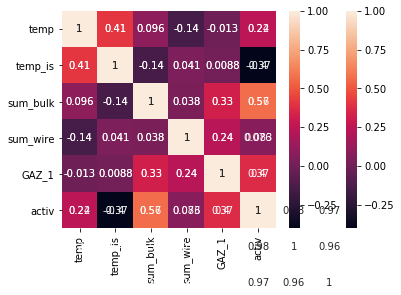

In [8]:
df_feature_target = df_filtr_time_3.rename(columns = {'Температура':'temp', 'Температура_нач':'temp_is', 
                                                      'время нагрева дугой': 'hot time', 'полная мощность': 'full power',
                                                      'sum_bulk':'sum_bulk', 'sum_wire':'sum_wire', 'Газ 1':'GAZ_1',
                                                      'Реактивная мощность': 'reactiv', 'Активная мощность': 'activ', 
                                                      'совершенная работа': 'work'})
df_feature_target_with_work = df_feature_target[['temp', 'temp_is', 'sum_bulk','sum_wire','GAZ_1', 'work']]
df_feature_target_with_full_power = df_feature_target[['temp','temp_is','sum_bulk','sum_wire','GAZ_1','hot time','full power']]
df_feature_target_without_changes  = df_feature_target[['temp','temp_is','sum_bulk','sum_wire','GAZ_1','hot time','activ', 'reactiv']]
df_feature_target_with_work.info()
df_feature_target_with_full_power.info()
df_feature_target_without_changes.info()
display(df_feature_target_without_changes.tail())
display(df_feature_target_without_changes.head())
corr_matrix = df_feature_target_without_changes.corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True)
df_feature_target_without_changes = df_feature_target_without_changes[['temp','temp_is','sum_bulk','sum_wire','GAZ_1','activ']]
corr_matrix = df_feature_target_without_changes.corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True)

# Вывод

Данные подготовлены в виде 3-х датасетов. В одном из них данные не подвергались изменениям, во втором датасете активная и реактивная мощности были преобразованы в полную мощность, в третьем - мощность и время теплового воздействия преобразованы в совершенную работу. Обучив модель на разных датасетах проверим, какие данные наиболее информативны для предсказания конечной температуры ковша. Произведен анализ на предмет мультиколлинеарности изначальных признаков. 

In [9]:
%%time
features = df_feature_target_without_changes.drop(['temp'], axis = 1)
#features.info()
target = df_feature_target_without_changes['temp']
#display(target.head(10))
names = list(features.columns)
scaler = StandardScaler()
scaler.fit(features[names])
features[names] = scaler.transform(features[names])
#display(features.head(10))
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target,
                                                                                        test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,target_valid_test,
                                                                            test_size = 0.5, random_state = 12345)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better= False)
model = lgb.LGBMRegressor()
grid = GridSearchCV(estimator = model,
                                param_grid={'n_estimators': [i for i in range(500, 1001, 100)], 'max_depth' : [4,5,7,9],
                                            'learning_rate': [0.02,0.04,0.07, 0.1], 'random_state': [12345]},
                                scoring = mae_scorer, cv = 5)
grid.fit(features_train, target_train)
print("Для lgbm-модели лучшее значение mae", (grid.best_score_))
print("Для lgbm-модели значение параметров", grid.best_params_)
print("---------------------------------------------")

Для lgbm-модели лучшее значение mae -6.816964309329268
Для lgbm-модели значение параметров {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 500, 'random_state': 12345}
---------------------------------------------
CPU times: user 37min 16s, sys: 28.9 s, total: 37min 44s
Wall time: 38min 28s


# Вывод

Произвел подбор параметров для модели LGBM в отдельном окне, поскольку данный процесс занимает продолжительное время. Как оказалось (в дальнейшем), наиболее подходящим для предсказания температуры ковша является датасет с большим количеством параметров (df_feature_target_without_changes). Эти параметры будут использованы для провеки качества работы модели на тестовой выборке.

In [10]:
%%time

best_mae_forest = {}
best_mae_regress = {}
best_mae_lgbm = {}


def RandomForestRegress(df_feature_target):
    features = df_feature_target.drop(['temp'], axis = 1)
#features.info()
    target = df_feature_target['temp']
#display(target.head(10))
    names = list(features.columns)
    scaler = StandardScaler()
    scaler.fit(features[names])
    features[names] = scaler.transform(features[names])
#display(features.head(10))
    features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target,
                                                                                            test_size = 0.4, random_state = 12345)
    features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,target_valid_test,
                                                                                test_size = 0.5, random_state = 12345)
    #features_train.info()
    #features_valid_test.info()
    #print(len(target_train))
    #print(len(target_valid_test))
    #print('--------------------------------')
    #
    #features_valid.info()
    #features_test.info()
    #print(len(target_valid))
    #print(len(target_test))
#mae = mean_absolute_error(target, predict)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better= False)
    model_1 = RandomForestRegressor()
    grid = GridSearchCV(estimator = model_1,
                                param_grid={'n_estimators': [i for i in range(3, 5)], 'max_depth' : [c for c in range(3, 10)],
                                           'random_state': [12345]},
                                scoring = mae_scorer, cv = 5) 
    model_1_1 = grid.fit(features_train, target_train)
    best_mae_forest['train'] = abs(grid.best_score_)

    #print("Для случайного леса наилучшее значение mae", grid.best_score_,'достигается при', grid.best_params_)
    #print("---------------------------------------------")
    model_1_2 = grid.fit(features_valid, target_valid)
    best_mae_forest['valid'] = abs(grid.best_score_)
    #print("Для случайного леса по валидационным данным значение mae", grid.best_score_)
    #print("---------------------------------------------")
    model_1_3 = grid.fit(features_test, target_test)
    best_mae_forest['test'] = abs(grid.best_score_)
    predicted_1_3 = model_1_3.predict(features_test)
    df_predict = pd.DataFrame({'predicted_forest': predicted_1_3 ,'target':target_test})
    #print("Для случайного леса по тестовым данным значение mae", grid.best_score_)
    #print("---------------------------------------------")
    #print(best_mae_forest)
    model = LinearRegression()
    grid = GridSearchCV(estimator = model,
                                    param_grid={},
                                    scoring = mae_scorer, cv = 5) 
    model_2_1 = grid.fit(features_train, target_train)
    best_mae_regress['train'] = abs(grid.best_score_)
    #print("Для линейной регрессии наилучшее значение mae", grid.best_score_)
    #print("---------------------------------------------")
    model_2_2 = grid.fit(features_valid, target_valid)
    best_mae_regress['valid'] = abs(grid.best_score_)
    #print("Для линейной регрессии по валидационным данным значение mae", grid.best_score_)
    #print("---------------------------------------------")
    model_2_3 = grid.fit(features_test, target_test)
    best_mae_regress['test'] = abs(grid.best_score_)
    predicted_2_3 = model_2_3.predict(features_test)
    df_predict['predicted_regress'] = predicted_2_3
    #print("Для линейной регрессии по тестовым данным значение mae", grid.best_score_)
    #print("---------------------------------------------")
    model_1 = lgb.LGBMRegressor(n_estimators = 700, max_depth = 4, learning_rate = 0.020, random_state = 12345)
    model_1.fit(features_train, target_train)
    print('==========feature impotance===================')
    importances = model_1.feature_importances_
    feature_list = list(features_train.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
    feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
    display(feature_results.head(10))
    predicted = model_1.predict(features_train) 
    mae_lgbm = mean_absolute_error(target_train, predicted)
    best_mae_lgbm['train'] = mean_absolute_error(target_train, predicted)
    #print("Для градиентного бустинга по тренировочным данным значение mae", mae_lgbm)
    #print("---------------------------------------------")
    predicted = model_1.predict(features_valid)
    mae_lgbm = mean_absolute_error(target_valid, predicted)
    #print("Для градиентного бустинга по валидационным данным значение mae", mae_lgbm)
    #print("---------------------------------------------")
    best_mae_lgbm['valid'] = mean_absolute_error(target_valid, predicted)
    predicted = model_1.predict(features_test)
    mae_lgbm = mean_absolute_error(target_test, predicted)
    df_predict['predicted_lgbm'] = predicted
    #print("Для градиентного бустинга по тестовым данным значение mae", mae_lgbm)
    #print("---------------------------------------------")
    best_mae_lgbm['test'] = mean_absolute_error(target_test, predicted)
    plt.figure(figsize = (8,5))
    sns.kdeplot(df_predict['predicted_forest'], shade = True, alpha = 0.4, linewidth = 3)
    sns.kdeplot(df_predict['predicted_regress'], shade = True, alpha = 0.4, linewidth = 3)
    sns.kdeplot(df_predict['target'], shade = True, alpha = 0.8, linewidth = 3)
    sns.kdeplot(df_predict['predicted_lgbm'], shade = True, alpha = 0.4, linewidth = 3)
    plt.legend(['predicted_forest','predicted_regress' ,'target', 'predicted_lgbm'])
    plt.xlabel('Temperature')
    plt.title('Predict and target')

    return best_mae_forest, best_mae_regress, best_mae_lgbm  


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


# Вывод

Реализована функциия RandomForestRegressLGBM для оценки качества предсказания на различных датасетах и различных моделях, среди которых алгоритмы RandomForest, LinearRegression и LGBM. Также по результатам формируется график плотности распределения, где наглядно видно качество предсказания моделей.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The def

==========feature impotance===================


,feature,importance
0,activ,1443
1,sum_wire,1425
2,temp_is,1069
3,GAZ_1,1016
4,sum_bulk,886


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


==========feature impotance===================


,feature,importance
0,sum_wire,1529
1,work,1219
2,temp_is,1065
3,GAZ_1,1019
4,sum_bulk,891


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The def

==========feature impotance===================


,feature,importance
0,sum_wire,1237
1,full power,1162
2,temp_is,996
3,GAZ_1,886
4,sum_bulk,824
5,hot time,669


,train,valid,test,name
2,5.227866,6.330721,6.657929,best_mae_lgbm_without_changes
8,5.316402,6.536587,6.886364,best_mae_lgbm_with_full_power
5,5.458536,6.620691,6.983354,best_mae_lgbm_with_work
0,7.100558,7.054452,7.490453,best_mae_forest_without_changes
6,7.199271,7.149277,7.575313,best_mae_forest_with_full_power
3,7.312411,7.394144,7.733284,best_mae_forest_with_work
1,7.792527,8.142519,8.013635,best_mae_regress_without_changes
7,7.859847,8.230049,8.163298,best_mae_regress_with_full_power
4,8.604382,8.594169,8.703635,best_mae_regress_with_work


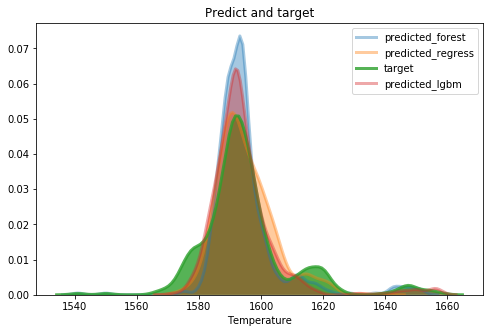

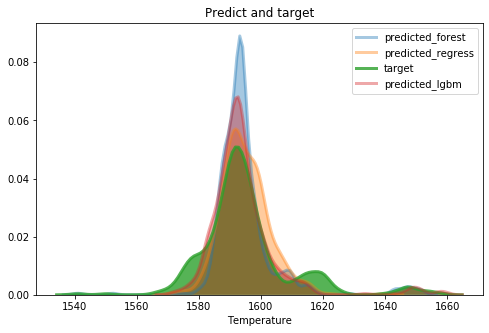

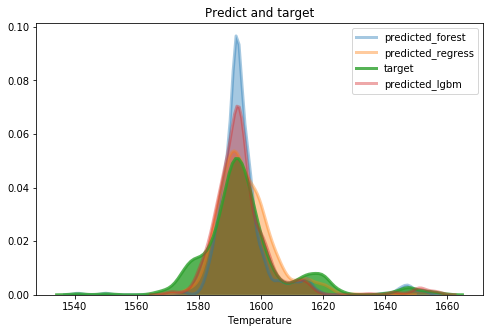

In [11]:
mae_1 = []
RandomForestRegress(df_feature_target_without_changes)
best_mae_forest_1 = best_mae_forest
best_mae_regress_1 = best_mae_regress 
best_mae_lgbm_1 = best_mae_lgbm
best_mae_forest_1['name'] = 'best_mae_forest_without_changes'
best_mae_regress_1['name'] = 'best_mae_regress_without_changes'
best_mae_lgbm_1 ['name'] = 'best_mae_lgbm_without_changes'
mae_1.append(best_mae_forest_1)
mae_1.append(best_mae_regress_1)
mae_1.append(best_mae_lgbm_1)


df_mae_full = pd.DataFrame(mae_1)
#display(df_mae_full)

RandomForestRegress(df_feature_target_with_work)
best_mae_forest_2 = best_mae_forest
best_mae_regress_2 = best_mae_regress
best_mae_lgbm_2 = best_mae_lgbm
best_mae_forest_2['name'] = 'best_mae_forest_with_work'
best_mae_regress_2['name'] = 'best_mae_regress_with_work'
best_mae_lgbm_2['name'] = 'best_mae_lgbm_with_work'
#print(best_mae_forest, best_mae_regress)

df_mae_full = df_mae_full.append(best_mae_forest_2, ignore_index = True)
df_mae_full = df_mae_full.append(best_mae_regress_2, ignore_index = True)
df_mae_full = df_mae_full.append(best_mae_lgbm_2, ignore_index = True)
#display(df_mae_full)

RandomForestRegress(df_feature_target_with_full_power)
best_mae_forest_3 = best_mae_forest
best_mae_regress_3 = best_mae_regress
best_mae_lgbm_3 = best_mae_lgbm
best_mae_forest_3['name'] = 'best_mae_forest_with_full_power'
best_mae_regress_3['name'] ='best_mae_regress_with_full_power'
best_mae_lgbm_3['name'] ='best_mae_lgbm_with_full_power'
#print(best_mae_forest, best_mae_regress)

df_mae_full = df_mae_full.append(best_mae_forest_3, ignore_index = True)
df_mae_full = df_mae_full.append(best_mae_regress_3, ignore_index = True)
df_mae_full = df_mae_full.append(best_mae_lgbm_3, ignore_index = True)
display(df_mae_full.sort_values(by = 'test', ascending  = True))

# Вывод
По результатам анализа работы моделй на различных датасетах выяснилось, что датасет с наибольшим количеством параметров (без изменений харатктеристик) оказался наиболее информативным. Также в данном пункте сформирована таблица, для которой определена характеристика mae для различных выборок, датасетов и моделей. Наилучшие значения mae показала модель LGBM на наборе данных df_feature_target_without_changes с результатам 6.657 для тестовых данных. Этот показатель является ниже порогового значения 6,8 градуса, что удовлетворяет заказчика. Соответственно проведенный анализ данных осуществлен должным образом и  модель может быть использована для решения бизнес задач. 

## План выполнения проекта

### Информационный анализ всех датасетов на предмет выявления аномалий, выбросов и отклонения показателей, их удаление, замена или соответствующая интерпретация. 

### Преобразование форматов данных и выделение наиболее актуальных признаков для полноценного формирования выборок. Объедиение данных из нескольких файловв один датасет.

### Рассмотрение возможности преобразования имеющихся в датасетах величин в более наглядные и всеобъемлющие (преобразование активной и реактивной в полную мощность, мощности и времени нагрева в совершенную работу). Необходимо оценить качество предсказания моделей в зависимости от преобразования данных и выбрать наилучший вариант.

### Формирование тестовой, тренировочной и валидационной выборок, применение процедур кодирования и стандартизации данных. 

### Применение различных моделей, подбор гиперпараметров и параметров, выбор наиболее качественной модели по метрике mae.